# Predcition of Hospital Admission Related to Otitis Externa

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to otitis externa. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [49]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats as st
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [50]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [51]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [52]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'ot_externa_date_'+str(i), 'ot_externa_ab_date_'+str(i), 'ot_externa_ab_type_'+str(i),
                   'incdt_ot_externa_date_'+str(i), 'admitted_ot_externa_date_'+str(i), 'sgss_gp_cov_ot_externa_date_'+str(i)]]
    
    #drop rows with no ot_externa reord
    datum = datum[datum['ot_externa_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with ot_externa_i
    datum = datum[datum['sgss_gp_cov_ot_externa_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'ot_externa_date_'+str(i): 'ot_externa_date', 'ot_externa_ab_date_'+str(i): 'ot_externa_ab_date', 
                           'ot_externa_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_ot_externa_date_'+str(i): 'incdt_ot_externa_date', 'incdt_ot_externa_type_'+str(i): 'incdt_ot_externa_type',
                           'admitted_ot_externa_date_'+str(i): 'admitted_ot_externa_date',
                           'sgss_gp_cov_ot_externa_date_'+str(i): 'sgss_gp_cov_ot_externa_date'},
                inplace=True)
    
    return datum

In [53]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [54]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [55]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_ot_externa_admitted',
            event_col='event_ot_externa_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_ot_externa_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [56]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    #save prob_pred_enc_lr_rf for analysis in r
    prob_pred_enc_lr_rf.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier()#n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #caculate ORs and intervals of LR model, save and print them 
    # lr_coef = pd.DataFrame({"or": lr.coef_})#, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef_exp = np.exp(lr_coef)
    # lr_coef_exp.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    # lr_coef = lr.coef_
    # print('LR ORs:\n %s'%(lr_coef))
    # lr_coef = pd.DataFrame(data=np.exp(lr.coef_), index=data_enc_dev_x.columns, columns=['lr_coef'])
    # lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    # lr_coef = pd.DataFrame(data=lr.coef_.T, index=data_enc_dev_x.columns, columns=['lr_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # # lr_coef['lr_coef_lower_bound'] = st.norm.ppf(lr_coef['lr_coef'])
    
    # alpha = 0.05
    # #the coefficients of the regression model
    # coefs = np.r_[lr.coef_.T.tolist()]#[lr.intercept_], lr.coef_.T.tolist()
    # #build an auxiliary dataframe with the constant term in it
    # X_aux = data_enc_dev_x.copy()
    # index = X_aux.columns
    # #add a column with constant value of 1 
    # X_aux.insert(0, 'const', 1)
    # #normal distribution table lookup
    # z_val = stats.norm.ppf(1 - alpha/2)
    # #inverse of the variance of the parameters using covariance matrix
    # var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    # #distance between lower and upper bound of CI
    # gap = z_val * np.sqrt(var_params)
    # #keep gaps of covariate columns (excluding the column with constant)
    # gap_coefs = gap[1:len(coefs)+1]
    # #create table of coefficients and their intervals and odds ratios and their intervals
    # lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap_coefs, 'coef_upper': coefs.ravel() + gap_coefs}, index=index)
    # lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # rf_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [57]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                #    'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_status_smoker', 'smoking_status_never_smoked', 'smoking_status_unknown', #'smoking_status_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    # #print summary of LR model
    # lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef = np.exp(lr_coef)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    # print('LR coefficients:\n %s'%(lr_coef))
    
#     alpha = 0.05
#     #the coefficients of the regression model
#     coefs = np.r_[lr.coef_.T.tolist()] #[lr.intercept_], lr.coef_.T.tolist()
#     #build an auxiliary dataframe with the constant term in it
#     X_aux = data_enc_dev_x.copy()
#    #  X_aux.insert(0, 'const', 1)
#     #degrees of freedom
#     dof = -np.diff(X_aux.shape)[0]
#     #Student's t-distribution table lookup
#     t_val = stats.t.isf(alpha/2, dof)
#     #MSE of the residuals
#     mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
#     #inverse of the variance of the parameters
#     var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
#     #distance between lower and upper bound of CI
#     gap = t_val * np.sqrt(mse * var_params)
#     lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
#     lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
#     # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
#     lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [58]:
#bootstrap and create lr models
def lr_bootstrap(data):
    sample = data.sample(data.shape[0], replace=True)
    X_tr = sample[[c for c in sample.columns if c != 'ab_binary']]
    y_tr = sample.ab_binary
    lr = LogisticRegression().fit(X_tr, y_tr)
    params = list(lr.coef_[0]) 

    return params

In [59]:
#calculate mean and standard error of lr models with bootstraped data to calculate mean coeffients and intervals of coefficients and odds ratios and their intervals
def get_lr_betas_intervals(data):
    #get column names of inputs
    data_x_columns = data.drop('ab_binary', axis=1).columns
    #create lr models with bootstraped samples for 100 times
    params_samples = pd.DataFrame([lr_bootstrap(data) for _ in range(100)])
    #calculate mean and standard error for coefficients of lrs with samples
    coefs_mean = params_samples.mean()
    coefs_se = params_samples.std()
    z_val = stats.norm.ppf(0.975)
    coefs_se_z_val = coefs_se * z_val
    #create a table of coefficients and their intervals for covariates 
    lr_summary = pd.DataFrame({'covariate': data_x_columns.tolist(), 'coef': coefs_mean, 'coef_lower_95%': coefs_mean - coefs_se_z_val, 'coef_upper_95%': coefs_mean + coefs_se_z_val})
    #clculate odds ratios and their intervals for covariates
    lr_summary[['or', 'or_lower_95%', 'or_upper_95%']] = np.exp(lr_summary[['coef', 'coef_lower_95%', 'coef_upper_95%']])

    return lr_summary

In [60]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):#, rf_pred_dev, rf_pred_val):
    # ##calibration for RF
    # rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    # #
    # rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    # #plot calibration plot for RF model with development and validation data
    # fig, ax1 = plt.subplots(figsize=(7, 7))
    # plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    # plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    # plt.xlabel('Mean predicted probabilities', fontsize=14)
    # plt.ylabel('Proportion of observed values', fontsize=14)
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=12, rotation=0)
    # plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    # plt.title("Calibration plot of RF model", fontsize=14)
    # legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    # legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    # plt.legend(handles=[legend_dev, legend_val])
    # plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    # plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [61]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_ot_externa.csv.gz')

In [62]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [63]:
#process 20 ot_externas and concatenate them 
data_ot_externa_1 = proc_infec_data(data,1)
data_ot_externa_2 = proc_infec_data(data,2)
data_ot_externa_3 = proc_infec_data(data,3)
data_ot_externa_4 = proc_infec_data(data,4)
data_ot_externa_5 = proc_infec_data(data,5)
data_ot_externa_6 = proc_infec_data(data,6)
data_ot_externa_7 = proc_infec_data(data,7)
data_ot_externa_8 = proc_infec_data(data,8)
data_ot_externa_9 = proc_infec_data(data,9)
data_ot_externa_10 = proc_infec_data(data,10)
data_ot_externa_11 = proc_infec_data(data,11)
data_ot_externa_12 = proc_infec_data(data,12)
data_ot_externa_13 = proc_infec_data(data,13)
data_ot_externa_14 = proc_infec_data(data,14)
data_ot_externa_15 = proc_infec_data(data,15)
data_ot_externa_16 = proc_infec_data(data,16)
data_ot_externa_17 = proc_infec_data(data,17)
data_ot_externa_18 = proc_infec_data(data,18)
data_ot_externa_19 = proc_infec_data(data,19)
data_ot_externa_20 = proc_infec_data(data,20)

data_ot_externa = pd.concat([data_ot_externa_1, data_ot_externa_2, data_ot_externa_3, data_ot_externa_4, data_ot_externa_5, data_ot_externa_6, data_ot_externa_7, data_ot_externa_8, data_ot_externa_9, data_ot_externa_10, data_ot_externa_11, data_ot_externa_12, data_ot_externa_13, data_ot_externa_14, data_ot_externa_15, data_ot_externa_16, data_ot_externa_17, data_ot_externa_18, data_ot_externa_19, data_ot_externa_20])
data_ot_externa.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [64]:
##add variable season
#convert data types
data_ot_externa['ot_externa_date'] = data_ot_externa['ot_externa_date'].astype('datetime64[ns]')
data_ot_externa['admitted_ot_externa_date'] = data_ot_externa['admitted_ot_externa_date'].astype('datetime64[ns]')
data_ot_externa.died_date = data_ot_externa.died_date.astype('datetime64[ns]')
data_ot_externa.deregistered_date = data_ot_externa.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_ot_externa['date'] = data_ot_externa['ot_externa_date'] 
data_ot_externa['date'] = data_ot_externa['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_ot_externa with today's date in year and month
data_ot_externa = data_ot_externa[data_ot_externa['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_ot_externa = data_ot_externa[data_ot_externa['date'] != last_1_month_date_y_m]
data_ot_externa = data_ot_externa[data_ot_externa['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of ot_externa records
data_ot_externa['season'] = np.nan
data_ot_externa['date_month'] = pd.DatetimeIndex(data_ot_externa['date']).month

conditions = [
    (data_ot_externa['date_month'] >= 3) & (data_ot_externa['date_month'] <= 5),
    (data_ot_externa['date_month'] >= 6) & (data_ot_externa['date_month'] <= 8),
    (data_ot_externa['date_month'] >= 9) & (data_ot_externa['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_ot_externa['season'] = np.select(conditions, choices, default='winter')

In [65]:
#add variable time period
data_ot_externa.loc[(data_ot_externa['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_ot_externa.loc[((data_ot_externa['date'] >= '2020-05') & (data_ot_externa['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_ot_externa.loc[(data_ot_externa['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

In [66]:
data_ot_externa['date'].max()

'2023-05'

#### event and duration

In [67]:
#scenario 1
#not hosped (nothing happened)
data_ot_externa.loc[data_ot_externa['admitted_ot_externa_date'].isnull(), 'event_ot_externa_admitted'] = 0

In [68]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_ot_externa['delta_ot_externa_admitted'] = (data_ot_externa['admitted_ot_externa_date'] - data_ot_externa['ot_externa_date']).dt.days
data_ot_externa.loc[((data_ot_externa['delta_ot_externa_admitted'] >= 0) & (data_ot_externa['delta_ot_externa_admitted'] <= 30)), 'event_ot_externa_admitted'] = 1

#scenario 2
#drop whoever was admitted before ot_externa consultation, i.e. negative value for delta_ot_externa_admitted
data_ot_externa = data_ot_externa[~(data_ot_externa['delta_ot_externa_admitted'] < 0)]

In [69]:
#scenario 3
#censor died patients
data_ot_externa['delta_admitted_died'] = (data_ot_externa['died_date'] - data_ot_externa['admitted_ot_externa_date']).dt.days
data_ot_externa.loc[data_ot_externa['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_ot_externa.loc[((data_ot_externa['delta_admitted_died'] >= 0) & (data_ot_externa['delta_admitted_died'] <= 30)), 'event_ot_externa_admitted'] = 0

#scenario 3
#censor deregistered patients
data_ot_externa['delta_admitted_deregistered'] = (data_ot_externa['deregistered_date'] - data_ot_externa['admitted_ot_externa_date']).dt.days
data_ot_externa.loc[data_ot_externa['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_ot_externa.loc[((data_ot_externa['delta_admitted_deregistered'] > 0) & (data_ot_externa['delta_admitted_deregistered'] <= 30)), 'event_ot_externa_admitted'] = 0

#agg scenario 3s
data_ot_externa['delta_admitted_died_deregistered'] = data_ot_externa['delta_admitted_deregistered'].combine_first(data_ot_externa['delta_admitted_died'])
data_ot_externa.loc[data_ot_externa['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [70]:
#scenario 1
#any other patients (nothing happened)
data_ot_externa['event_ot_externa_admitted'] = data_ot_externa['event_ot_externa_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_ot_externa['duration_ot_externa_admitted'] = data_ot_externa['delta_ot_externa_admitted'].combine_first(data_ot_externa['delta_admitted_died_deregistered'])
data_ot_externa['duration_ot_externa_admitted'] = data_ot_externa['duration_ot_externa_admitted'].replace(np.NaN, 30)
data_ot_externa.loc[(data_ot_externa['duration_ot_externa_admitted'] > 30), 'duration_ot_externa_admitted'] = 30

#give value 1 to event_ot_externa_admitted if duration_ot_externa_admitted is greater or equal to 0 and less than 30
data_ot_externa.loc[((data_ot_externa['duration_ot_externa_admitted'] >= 0) & (data_ot_externa['duration_ot_externa_admitted'] < 30)), 'event_ot_externa_admitted'] = 1

#drop any rows with value 0 in duration column
data_ot_externa = data_ot_externa[~(data_ot_externa['duration_ot_externa_admitted'] == 0)]

In [71]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_ot_externa.loc[((data_ot_externa['delta_ot_externa_admitted'] > 0) & (data_ot_externa['delta_ot_externa_admitted'] < 30)), 'event_ot_externa_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [72]:
#drop anybody with age less than 18 or 0!
data_ot_externa = data_ot_externa[~(data_ot_externa['age'] < 18)] 
data_ot_externa['age'][data_ot_externa['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_ot_externa = data_ot_externa[data_ot_externa['age_cat'] != '0-4']
data_ot_externa = data_ot_externa[data_ot_externa['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_ot_externa['bmi'][data_ot_externa['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_ot_externa['bmi'] = data_ot_externa['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_ot_externa['antibacterial_brit'][data_ot_externa['antibacterial_brit'] < 0] = np.nan

In [73]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking_status = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_ot_externa = data_ot_externa.replace({"sex": dict_sex})
data_ot_externa = data_ot_externa.replace({"smoking_status": dict_smoking_status})

In [74]:
#drop rows with missing region
if ('region' in data_ot_externa.columns) and (data_ot_externa['region'].isnull().sum() > 0):
   data_ot_externa = data_ot_externa[data_ot_externa['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_ot_externa.columns) and (data_ot_externa['antibacterial_brit'].isnull().sum() > 0):
    data_ot_externa['antibacterial_brit'] = data_ot_externa['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_ot_externa.columns) and (data_ot_externa['ethnicity'].isnull().sum() > 0):
    data_ot_externa['ethnicity'] = data_ot_externa['ethnicity'].fillna(0)

#replace rows with missing smoking_status with 0
if ('smoking_status' in data_ot_externa.columns) and (data_ot_externa['smoking_status'].isnull().sum() > 0):
    data_ot_externa['smoking_status'] = data_ot_externa['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_ot_externa.columns) and (data_ot_externa['imd'].isnull().sum() > 0):
    data_ot_externa['imd'] = data_ot_externa['imd'].fillna(0)

In [75]:
#missing values of bmi assign 5 and 0; categorise bmi
data_ot_externa['bmi_cat'] = 5

for idx, x in enumerate(data_ot_externa['bmi_cat']):
    if data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] >= 30:
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] >= 25) and (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] < 30):
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] >= 18.5) and (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] < 25):
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] < 18.5:
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_ot_externa.columns) and (data_ot_externa['bmi_cat'].isnull().sum() > 0):
    data_ot_externa['bmi_cat'] = data_ot_externa['bmi_cat'].fillna(0)

In [76]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_ot_externa.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_ot_externa['ab_type_cat'] = np.where(data_ot_externa['ab_type'].isin(ab_series[mask].index),'other',data_ot_externa['ab_type'])
#assign no to non ab users
data_ot_externa.loc[data_ot_externa['ot_externa_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_ot_externa['ab_type_cat'] = data_ot_externa['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [77]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking_status = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_ot_externa = data_ot_externa.replace({"sex": dict_sex})
data_ot_externa = data_ot_externa.replace({"ethnicity": dict_ethnicity})
data_ot_externa = data_ot_externa.replace({"smoking_status": dict_smoking_status})
data_ot_externa = data_ot_externa.replace({"imd": dict_imd})
data_ot_externa = data_ot_externa.replace({"bmi_cat": dict_bmi})
data_ot_externa = data_ot_externa.replace({"flu_vaccine": dict_flu})
data_ot_externa = data_ot_externa.replace({"region": dict_region})
data_ot_externa = data_ot_externa.replace({"age_cat": dict_age})
data_ot_externa = data_ot_externa.replace({"ab_type_cat": dict_ab_type})

In [78]:
data_ot_externa.ethnicity.value_counts('NA')

white      0.597516
unknown    0.252698
other      0.074928
asian      0.074858
Name: ethnicity, dtype: float64

In [79]:
data_ot_externa.smoking_status.value_counts('NA')

unknown         0.413559
smoker          0.390942
never_smoked    0.131232
ex_smoker       0.064266
Name: smoking_status, dtype: float64

In [80]:
data_ot_externa.bmi_cat.value_counts('NA')

obese             0.518236
unknown           0.255457
overweight        0.111950
healthy_weight    0.081854
underweight       0.032502
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [81]:
#categorise CCI
data_ot_externa['CCI_cat'] = pd.cut(data_ot_externa['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_ot_externa['antibacterial_brit'].clip(0, data_ot_externa['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

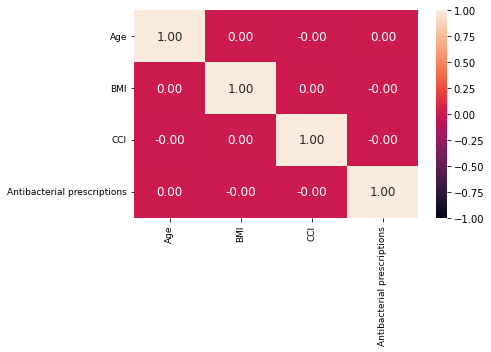

In [82]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_ot_externa[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/corr_ot_externa.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [83]:
data_ot_externa = data_ot_externa[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'ot_externa_ab_date', 'ab_type_cat', 'incdt_ot_externa_date', 'date', 'period',
                                   'event_ot_externa_admitted', 'duration_ot_externa_admitted'
                                    ]]

In [84]:
#switch variable ot_externa_ab_date into a binary variable
data_ot_externa[['ab_binary']] = data_ot_externa[['ot_externa_ab_date']].where(data_ot_externa[['ot_externa_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_ot_externa_incdt = data_ot_externa[data_ot_externa['incdt_ot_externa_date'] == 0]
data_ot_externa_prevl = data_ot_externa[data_ot_externa['incdt_ot_externa_date'] == 1]

#no antibiotics and incident hospital admission
data_ot_externa_no_abs_incdt = data_ot_externa_incdt[data_ot_externa_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_ot_externa_abs_incdt = data_ot_externa_incdt[data_ot_externa_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_ot_externa_no_abs_prevl = data_ot_externa_prevl[data_ot_externa_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_ot_externa_abs_prevl = data_ot_externa_prevl[data_ot_externa_prevl['ab_binary'] == 1]

In [85]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_ot_externa_incdt_prepandemic = data_ot_externa_incdt[data_ot_externa_incdt['period'] == 'prepandemic']
data_ot_externa_incdt_during_pandemic = data_ot_externa_incdt[(data_ot_externa_incdt['period'] == 'during_pandemic')]
data_ot_externa_incdt_post_2nd_lockdown = data_ot_externa_incdt[data_ot_externa_incdt['period'] == 'post_2nd_lockdown']
data_ot_externa_prevl_prepandemic = data_ot_externa_prevl[data_ot_externa_prevl['period'] == 'prepandemic']
data_ot_externa_prevl_during_pandemic = data_ot_externa_prevl[(data_ot_externa_prevl['period'] == 'during_pandemic')]
data_ot_externa_prevl_post_2nd_lockdown = data_ot_externa_prevl[data_ot_externa_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_ot_externa_no_abs_incdt_prepandemic = data_ot_externa_incdt_prepandemic[data_ot_externa_incdt_prepandemic['ab_binary'] == 0]
data_ot_externa_no_abs_incdt_during_pandemic = data_ot_externa_incdt_during_pandemic[data_ot_externa_incdt_during_pandemic['ab_binary'] == 0]
data_ot_externa_no_abs_incdt_post_2nd_lockdown = data_ot_externa_incdt_post_2nd_lockdown[data_ot_externa_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_ot_externa_no_abs_prevl_prepandemic = data_ot_externa_prevl_prepandemic[data_ot_externa_prevl_prepandemic['ab_binary'] == 0]
data_ot_externa_no_abs_prevl_during_pandemic = data_ot_externa_prevl_during_pandemic[data_ot_externa_prevl_during_pandemic['ab_binary'] == 0]
data_ot_externa_no_abs_prevl_post_2nd_lockdown = data_ot_externa_prevl_post_2nd_lockdown[data_ot_externa_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [86]:
#store data for plotting hosp admission counts and percentages
%store data_ot_externa
# save data
data_ot_externa.to_csv('../output/hospitalisation_prediction_ot_externa/data_ot_externa.csv')

Stored 'data_ot_externa' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [87]:
#make summary tables
make_summary_table('ot_externa', 'no_abs_incdt', data_ot_externa_no_abs_incdt)
make_summary_table('ot_externa', 'abs_incdt', data_ot_externa_abs_incdt)
make_summary_table('ot_externa', 'no_abs_prevl', data_ot_externa_no_abs_prevl)
make_summary_table('ot_externa', 'abs_prevl', data_ot_externa_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 112008 total observations, 111285 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 112008
number of events observed = 723
   partial log-likelihood = -8384.40
         time fit was run = 2023-08-08 08:52:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.11            -0.25             0.18                 0.78                 1.20
CCI_cat[T.medium]               -0.03       0.97       0.12            -0.27             0.20                 0.77                 1.23
CCI_cat[T.high]                 -0.09       0.92       0.15            -0.37             0.20                 0.69                 1.22
CCI_cat[T.very_high]            -0.16       0.85       0.13            -0.42             0.09                 0.66                 1.10
age_cat[T.25_34]                 0.26       1.30       0.14            -0.01             0.54                 0.99                 1.72
age_cat[T.35_44]                 0.18       1.20       0.14            -0.10             0.46                 0.90                 1.58
age_cat[T.45_54]                 0.22       1.24       0.14            -0.06             0.49                 0.94                 1.64
age_cat[T.55_64]                -0.00       1.00       0.15            -0.30             0.29                 0.74                 1.33
age_cat[T.65_74]                 0.15       1.16       0.14            -0.13             0.43                 0.87                 1.54
age_cat[T.75_more]               0.18       1.20       0.14            -0.10             0.46                 0.90                 1.59
antibacterial_brit               0.02       1.02       0.03            -0.04             0.07                 0.96                 1.07
bmi_cat[T.obese]                -0.08       0.92       0.14            -0.35             0.19                 0.70                 1.21
bmi_cat[T.overweight]           -0.10       0.90       0.17            -0.44             0.23                 0.65                 1.26
bmi_cat[T.underweight]           0.28       1.33       0.22            -0.15             0.71                 0.86                 2.03
bmi_cat[T.unknown]               0.01       1.01       0.15            -0.28             0.29                 0.76                 1.34
ethnicity[T.other]               0.29       1.34       0.19            -0.08             0.67                 0.93                 1.94
ethnicity[T.unknown]             0.02       1.02       0.16            -0.29             0.34                 0.75                 1.41
ethnicity[T.white]               0.11       1.12       0.15            -0.18             0.41                 0.83                 1.51
flu_vaccine[T.yes]              -0.02       0.98       0.13            -0.26             0.23                 0.77                 1.26
imd[T.medium]                   -0.12       0.89       0.12            -0.36             0.13                 0.70                 1.14
imd[T.unaffluent]                0.06       1.06       0.12            -0.17             0.29                 0.84                 1.34
imd[T.unknown]                  -0.16       0.86       0.20            -0.54             0.23                 0.58                 1.26
imd[T.very_affluent]             0.12       1.13       0.12            -0.10             0.35                 0.90                 1.42
imd[T.very_unaffluent]          -0.06       0.94       0.12            -0.30             0.18                 0.74                 1.20
region[T.east_midlands]          0.30       1.35     

13045


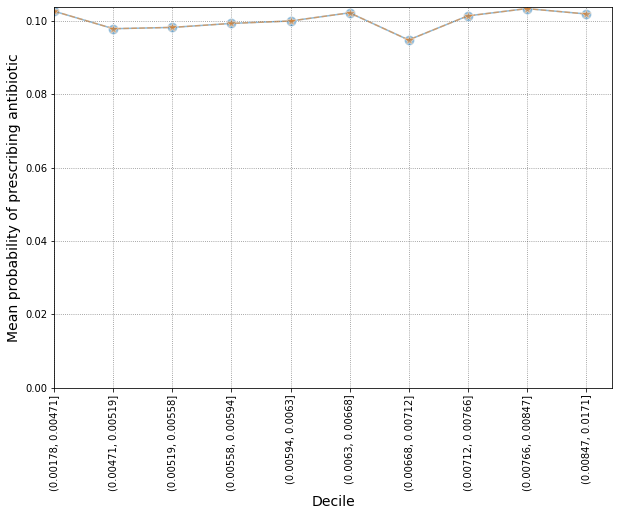


AUROC of LR for deciles with development and validation data: 0.50683 and 0.49510
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00471, 0.00519] -0.019312       -0.101146        0.062522   
1  bins_(0.00519, 0.00558] -0.071946       -0.140771       -0.003121   
2  bins_(0.00558, 0.00594] -0.019969       -0.104245        0.064308   
3   bins_(0.00594, 0.0063] -0.036284       -0.120904        0.048335   
4   bins_(0.0063, 0.00668] -0.032273       -0.115032        0.050487   
5  bins_(0.00668, 0.00712] -0.092945       -0.168494       -0.017397   
6  bins_(0.00712, 0.00766] -0.003240       -0.079679        0.073199   
7  bins_(0.00766, 0.00847] -0.025356       -0.106046        0.055334   
8   bins_(0.00847, 0.0171] -0.028829       -0.109894        0.052235   

         or  or_lower_95%  or_upper_95%  
0  0.980873      0.903801      1.064518  
1  0.930582      0.868689      0.996884  
2  0.980229      0.901005      1.066420  
3  0.964366    

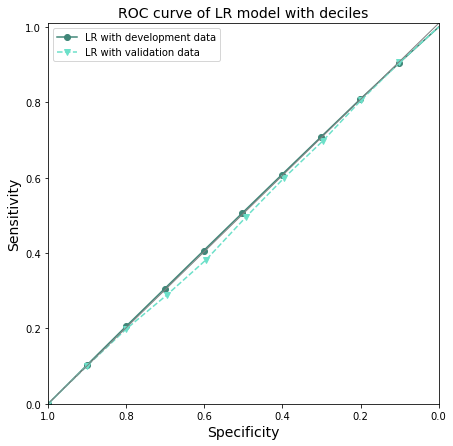

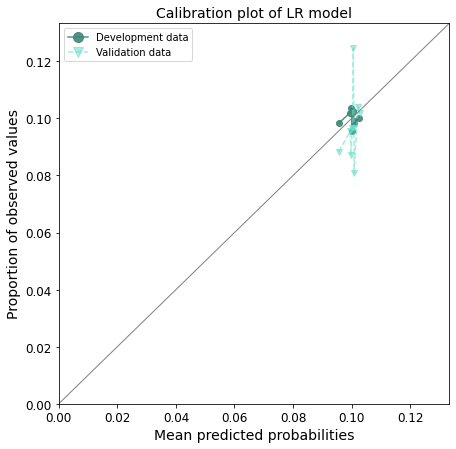


AUROC of LR for risk factors with development and validation data: 0.51560 and 0.49240
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34  0.046029       -0.023107        0.115164   
1                 age_cat_35_44  0.049285       -0.021209        0.119779   
2                 age_cat_45_54  0.051901       -0.019535        0.123336   
3                 age_cat_55_64  0.064491       -0.003070        0.132052   
4                 age_cat_65_74  0.031854       -0.039434        0.103143   
5               age_cat_75_more  0.029668       -0.035779        0.095115   
6                      sex_male  0.014258       -0.023876        0.052391   
7                  CCI_cat_high  0.030959       -0.043528        0.105446   
8                   CCI_cat_low  0.042639       -0.011768        0.097046   
9                CCI_cat_medium  0.013288       -0.044210        0.070785   
10            CCI_cat_very_high  0.077050        0.0

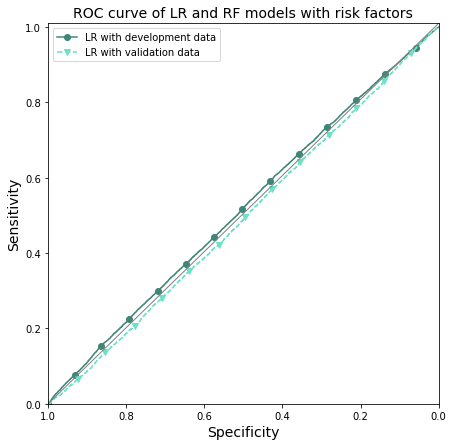

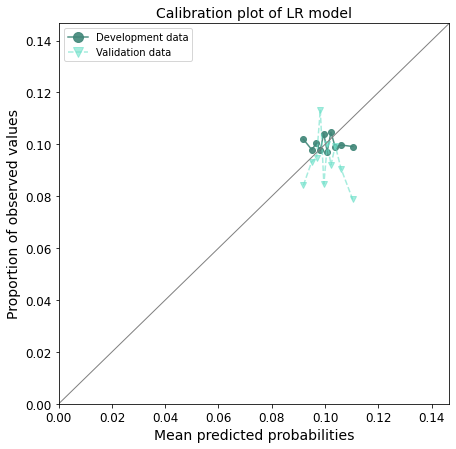

In [88]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_ot_externa_no_abs_incdt, prob_pred_ot_externa_no_abs_incdt_bin = cox_build('ot_externa', 'incdt', data_ot_externa_incdt, data_ot_externa_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_deciles('ot_externa', 'incdt_deciles', prob_pred_ot_externa_no_abs_incdt)
#calibration plots of rf and lr with deciles
calibration_rf_lr('ot_externa', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('ot_externa', 'incdt', prob_pred_enc_lr_rf_incdt)

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_riskfactors('ot_externa', 'incdt_riskfactors', prob_pred_ot_externa_no_abs_incdt)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('ot_externa', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

In [89]:
# alpha = 0.05
# #the coefficients of the regression model
# coefs = np.r_[[lr.intercept_], lr.coef_.T.tolist()]
# #build an auxiliary dataframe with the constant term in it
# X_aux = data_enc_dev_incdt_x.copy()
# X_aux.insert(0, 'const', 1)
# #degrees of freedom
# dof = -np.diff(X_aux.shape)[0]
# #Student's t-distribution table lookup
# t_val = stats.t.isf(alpha/2, dof)
# #MSE of the residuals
# mse = np.sum((data_enc_dev_incdt_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_incdt_x)) ** 2) / dof
# #inverse of the variance of the parameters
# var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
# #distance between lower and upper bound of CI
# gap = t_val * np.sqrt(mse * var_params)
# coef_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap})
# coef_ints

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12265 total observations, 12184 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 12265
number of events observed = 81
   partial log-likelihood = -741.25
         time fit was run = 2023-08-08 08:57:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.44       0.65       0.32            -1.06             0.18                 0.35                 1.20
CCI_cat[T.medium]               -0.16       0.85       0.34            -0.82             0.50                 0.44                 1.64
CCI_cat[T.high]                 -0.11       0.89       0.40            -0.90             0.67                 0.41                 1.96
CCI_cat[T.very_high]            -0.57       0.57       0.40            -1.35             0.22                 0.26                 1.24
age_cat[T.25_34]                 0.28       1.32       0.48            -0.65             1.21                 0.52                 3.36
age_cat[T.35_44]                 0.23       1.26       0.48            -0.70             1.16                 0.49                 3.18
age_cat[T.45_54]                 0.36       1.43       0.46            -0.54             1.25                 0.58                 3.51
age_cat[T.55_64]                 0.61       1.84       0.44            -0.25             1.47                 0.78                 4.35
age_cat[T.65_74]                 0.81       2.25       0.43            -0.03             1.65                 0.97                 5.22
age_cat[T.75_more]               0.06       1.07       0.49            -0.89             1.02                 0.41                 2.77
antibacterial_brit              -0.05       0.95       0.08            -0.20             0.11                 0.82                 1.12
bmi_cat[T.obese]                -0.44       0.64       0.35            -1.13             0.26                 0.32                 1.29
bmi_cat[T.overweight]           -1.00       0.37       0.55            -2.08             0.07                 0.12                 1.08
bmi_cat[T.underweight]          -0.29       0.75       0.66            -1.59             1.00                 0.20                 2.73
bmi_cat[T.unknown]              -0.33       0.72       0.38            -1.07             0.42                 0.34                 1.52
ethnicity[T.other]               0.30       1.35       0.65            -0.97             1.57                 0.38                 4.78
ethnicity[T.unknown]             0.66       1.94       0.54            -0.39             1.71                 0.68                 5.56
ethnicity[T.white]               0.26       1.30       0.52            -0.76             1.29                 0.47                 3.62
flu_vaccine[T.yes]               0.33       1.39       0.33            -0.31             0.97                 0.73                 2.63
imd[T.medium]                    0.06       1.06       0.37            -0.67             0.79                 0.51                 2.19
imd[T.unaffluent]                0.37       1.44       0.35            -0.32             1.06                 0.72                 2.89
imd[T.unknown]                   0.14       1.15       0.57            -0.98             1.25                 0.38                 3.49
imd[T.very_affluent]             0.02       1.02       0.38            -0.72             0.76                 0.49                 2.14
imd[T.very_unaffluent]           0.10       1.11       0.37            -0.63             0.83                 0.53                 2.30
region[T.east_midlands]          0.73       2.07       0.4

13048


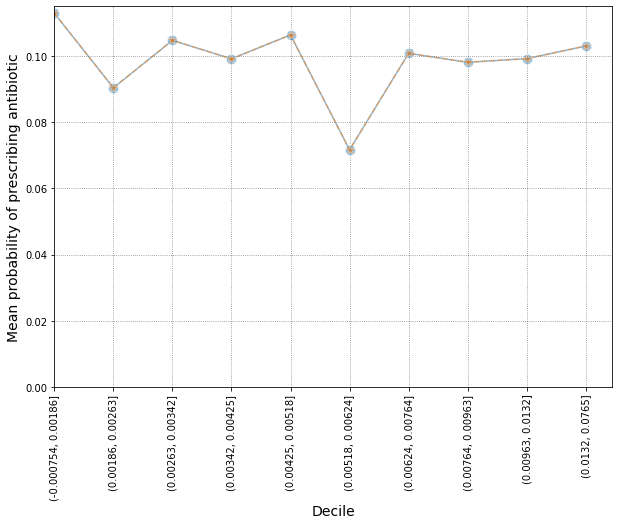


AUROC of LR for deciles with development and validation data: 0.53332 and 0.50909
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00186, 0.00263] -0.201597       -0.424614        0.021420   
1  bins_(0.00263, 0.00342] -0.041031       -0.274778        0.192716   
2  bins_(0.00342, 0.00425] -0.169493       -0.421053        0.082066   
3  bins_(0.00425, 0.00518]  0.027627       -0.192929        0.248184   
4  bins_(0.00518, 0.00624] -0.421307       -0.669893       -0.172721   
5  bins_(0.00624, 0.00764] -0.092529       -0.350478        0.165421   
6  bins_(0.00764, 0.00963] -0.141654       -0.396470        0.113162   
7   bins_(0.00963, 0.0132] -0.067091       -0.304015        0.169833   
8    bins_(0.0132, 0.0765]  0.009323       -0.235320        0.253965   

         or  or_lower_95%  or_upper_95%  
0  0.817424      0.654022      1.021651  
1  0.959799      0.759741      1.212538  
2  0.844092      0.656355      1.085528  
3  1.028013    

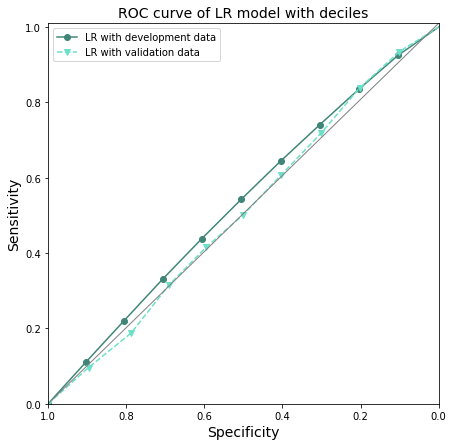

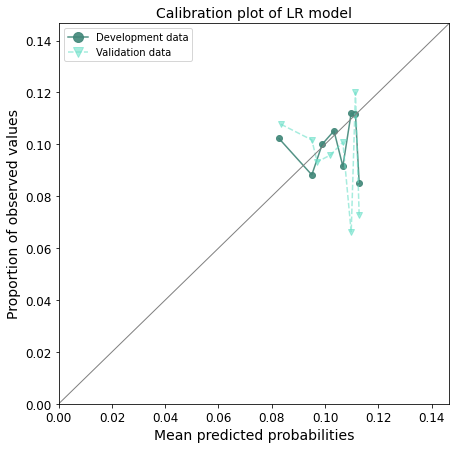


AUROC of LR for risk factors with development and validation data: 0.55048 and 0.51793
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34 -0.186640       -0.389140        0.015860   
1                 age_cat_35_44 -0.115656       -0.307027        0.075715   
2                 age_cat_45_54 -0.123726       -0.316827        0.069374   
3                 age_cat_55_64 -0.084188       -0.286168        0.117792   
4                 age_cat_65_74 -0.026946       -0.201458        0.147567   
5               age_cat_75_more -0.213313       -0.435877        0.009250   
6                      sex_male  0.016568       -0.089185        0.122321   
7                  CCI_cat_high -0.247880       -0.491614       -0.004147   
8                   CCI_cat_low -0.136576       -0.282159        0.009006   
9                CCI_cat_medium  0.002790       -0.156950        0.162531   
10            CCI_cat_very_high -0.021695       -0.1

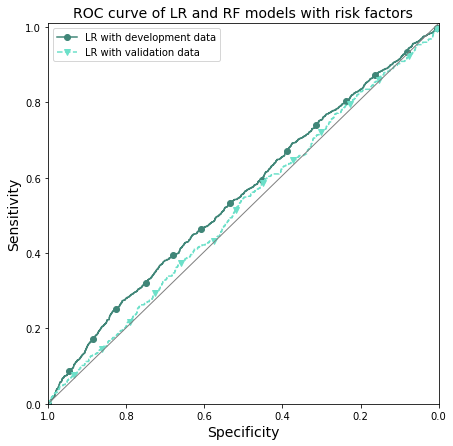

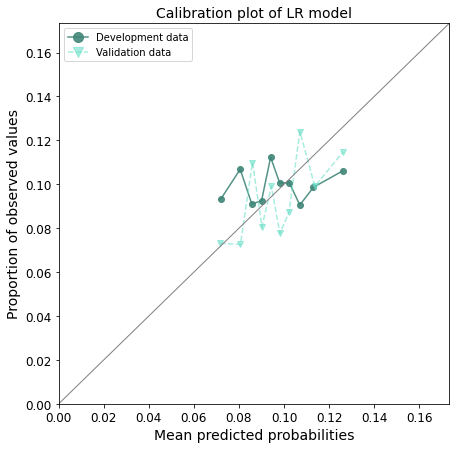

In [90]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_ot_externa_no_abs_prevl, prob_pred_ot_externa_no_abs_prevl_bin = cox_build('ot_externa', 'prevl', data_ot_externa_prevl, data_ot_externa_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_deciles('ot_externa', 'prevl_deciles', prob_pred_ot_externa_no_abs_prevl)
#calibration plots of rf and lr with deciles
calibration_rf_lr('ot_externa', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('ot_externa', 'prevl', prob_pred_enc_lr_rf_prevl)

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_riskfactors('ot_externa', 'prevl_riskfactors', prob_pred_ot_externa_no_abs_prevl)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('ot_externa', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 29035 total observations, 28877 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 29035
number of events observed = 158
   partial log-likelihood = -1601.98
         time fit was run = 2023-08-08 08:58:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.43       0.24            -0.12             0.83                 0.89                 2.29
CCI_cat[T.medium]               -0.18       0.83       0.29            -0.75             0.39                 0.47                 1.48
CCI_cat[T.high]                 -0.21       0.81       0.36            -0.91             0.48                 0.40                 1.62
CCI_cat[T.very_high]             0.19       1.20       0.28            -0.37             0.74                 0.69                 2.09
age_cat[T.25_34]                 0.23       1.25       0.30            -0.35             0.81                 0.70                 2.24
age_cat[T.35_44]                -0.10       0.91       0.32            -0.72             0.52                 0.49                 1.69
age_cat[T.45_54]                 0.07       1.07       0.31            -0.53             0.67                 0.59                 1.95
age_cat[T.55_64]                 0.14       1.15       0.30            -0.45             0.73                 0.64                 2.06
age_cat[T.65_74]                 0.29       1.34       0.29            -0.28             0.87                 0.76                 2.38
age_cat[T.75_more]              -0.01       0.99       0.31            -0.62             0.61                 0.54                 1.83
antibacterial_brit               0.03       1.03       0.06            -0.08             0.14                 0.93                 1.15
bmi_cat[T.obese]                -0.10       0.90       0.30            -0.69             0.49                 0.50                 1.63
bmi_cat[T.overweight]           -0.40       0.67       0.40            -1.19             0.39                 0.31                 1.47
bmi_cat[T.underweight]           0.62       1.87       0.42            -0.20             1.45                 0.82                 4.26
bmi_cat[T.unknown]               0.16       1.18       0.31            -0.45             0.78                 0.64                 2.18
ethnicity[T.other]               0.57       1.76       0.44            -0.30             1.44                 0.74                 4.20
ethnicity[T.unknown]             0.56       1.74       0.38            -0.19             1.30                 0.82                 3.69
ethnicity[T.white]               0.31       1.37       0.37            -0.41             1.04                 0.66                 2.82
flu_vaccine[T.yes]              -0.86       0.42       0.39            -1.62            -0.10                 0.20                 0.90
imd[T.medium]                   -0.14       0.87       0.25            -0.63             0.36                 0.53                 1.44
imd[T.unaffluent]               -0.21       0.81       0.26            -0.72             0.30                 0.49                 1.35
imd[T.unknown]                  -0.41       0.66       0.44            -1.29             0.46                 0.28                 1.58
imd[T.very_affluent]            -0.13       0.88       0.25            -0.63             0.37                 0.53                 1.45
imd[T.very_unaffluent]           0.02       1.02       0.24            -0.46             0.50                 0.63                 1.64
region[T.east_midlands]          0.18       1.20       0

13053


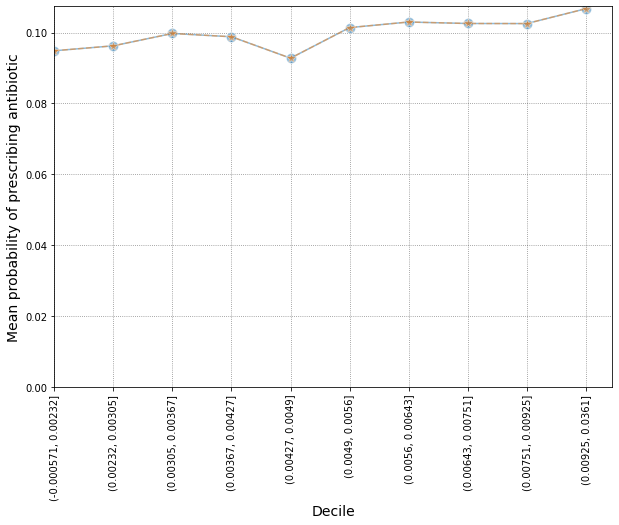


AUROC of LR for deciles with development and validation data: 0.51270 and 0.51009
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00232, 0.00305]  0.040897       -0.130307        0.212100   
1  bins_(0.00305, 0.00367]  0.036972       -0.131979        0.205924   
2  bins_(0.00367, 0.00427]  0.054418       -0.110110        0.218946   
3   bins_(0.00427, 0.0049] -0.013248       -0.172245        0.145749   
4    bins_(0.0049, 0.0056]  0.113964       -0.049200        0.277128   
5   bins_(0.0056, 0.00643]  0.120623       -0.037476        0.278723   
6  bins_(0.00643, 0.00751]  0.048050       -0.122906        0.219006   
7  bins_(0.00751, 0.00925]  0.095019       -0.066272        0.256310   
8   bins_(0.00925, 0.0361]  0.115388       -0.063944        0.294720   

         or  or_lower_95%  or_upper_95%  
0  1.041745      0.877826      1.236272  
1  1.037664      0.876359      1.228660  
2  1.055926      0.895736      1.244764  
3  0.986840    

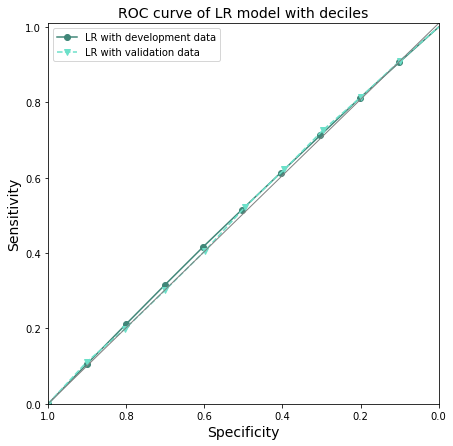

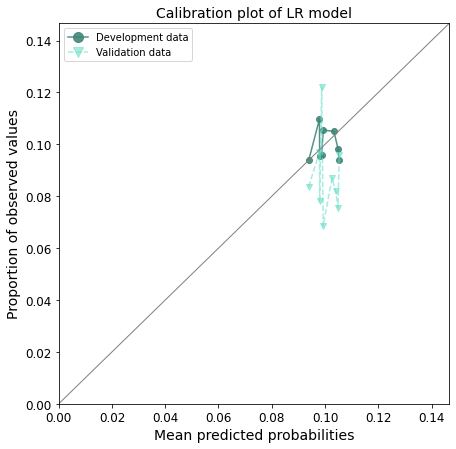

In [91]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_ot_externa_no_abs_incdt_prepandemic, prob_pred_ot_externa_no_abs_incdt_prepandemic_bin = cox_build('ot_externa', 'incdt_prepandemic', data_ot_externa_incdt_prepandemic, data_ot_externa_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('ot_externa', 'incdt_prepandemic_deciles', prob_pred_ot_externa_no_abs_incdt_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('ot_externa', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)#, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26263 total observations, 26102 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 26263
number of events observed = 161
   partial log-likelihood = -1618.01
         time fit was run = 2023-08-08 08:58:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.24            -0.70             0.23                 0.49                 1.26
CCI_cat[T.medium]                0.12       1.12       0.25            -0.37             0.60                 0.69                 1.82
CCI_cat[T.high]                  0.35       1.41       0.28            -0.19             0.89                 0.82                 2.43
CCI_cat[T.very_high]            -0.20       0.82       0.29            -0.76             0.36                 0.47                 1.43
age_cat[T.25_34]                 0.44       1.55       0.30            -0.16             1.03                 0.85                 2.80
age_cat[T.35_44]                 0.45       1.57       0.30            -0.14             1.04                 0.87                 2.83
age_cat[T.45_54]                 0.38       1.47       0.31            -0.22             0.98                 0.80                 2.68
age_cat[T.55_64]                -0.01       0.99       0.33            -0.67             0.64                 0.51                 1.90
age_cat[T.65_74]                 0.26       1.30       0.31            -0.36             0.88                 0.70                 2.40
age_cat[T.75_more]               0.10       1.11       0.33            -0.54             0.75                 0.58                 2.11
antibacterial_brit              -0.02       0.98       0.06            -0.13             0.09                 0.88                 1.10
bmi_cat[T.obese]                -0.11       0.90       0.30            -0.70             0.48                 0.50                 1.62
bmi_cat[T.overweight]            0.06       1.06       0.36            -0.64             0.76                 0.53                 2.14
bmi_cat[T.underweight]          -0.32       0.73       0.57            -1.44             0.81                 0.24                 2.24
bmi_cat[T.unknown]               0.15       1.16       0.31            -0.46             0.76                 0.63                 2.15
ethnicity[T.other]               0.36       1.43       0.43            -0.49             1.21                 0.61                 3.34
ethnicity[T.unknown]             0.12       1.12       0.37            -0.62             0.85                 0.54                 2.34
ethnicity[T.white]               0.36       1.43       0.35            -0.32             1.04                 0.72                 2.83
flu_vaccine[T.yes]              -0.13       0.87       0.28            -0.68             0.41                 0.50                 1.51
imd[T.medium]                    0.03       1.03       0.29            -0.54             0.60                 0.58                 1.81
imd[T.unaffluent]                0.42       1.52       0.26            -0.10             0.93                 0.90                 2.54
imd[T.unknown]                   0.45       1.57       0.38            -0.28             1.19                 0.75                 3.29
imd[T.very_affluent]             0.47       1.59       0.26            -0.05             0.98                 0.95                 2.67
imd[T.very_unaffluent]           0.29       1.33       0.27            -0.25             0.82                 0.78                 2.28
region[T.east_midlands]          0.60       1.81       0

13036


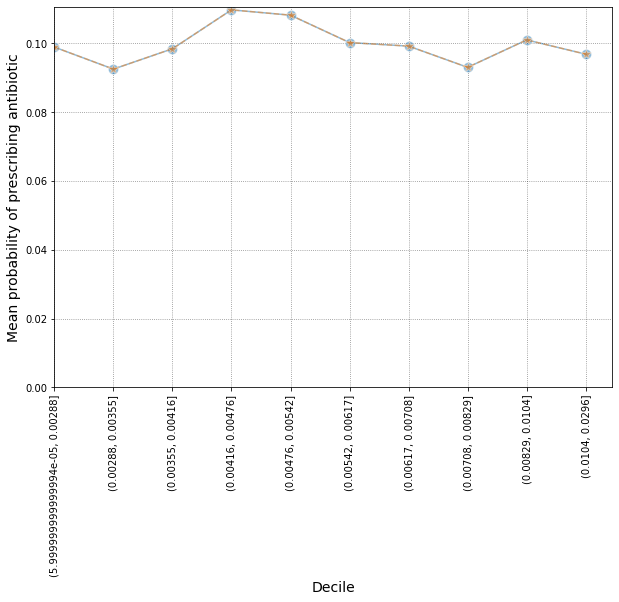


AUROC of LR for deciles with development and validation data: 0.51436 and 0.51950
LR summary:
                                covariate      coef  coef_lower_95%  \
0                bins_(0.00355, 0.00416]  0.081007       -0.099623   
1                bins_(0.00416, 0.00476]  0.144627       -0.043483   
2                bins_(0.00476, 0.00542]  0.173914        0.020032   
3                bins_(0.00542, 0.00617]  0.109264       -0.082285   
4                bins_(0.00617, 0.00708]  0.092131       -0.077717   
5                bins_(0.00708, 0.00829]  0.014654       -0.166027   
6                 bins_(0.00829, 0.0104]  0.117421       -0.061916   
7                  bins_(0.0104, 0.0296]  0.076475       -0.111933   
8  bins_(5.999999999999994e-05, 0.00288]  0.108991       -0.071658   

   coef_upper_95%        or  or_lower_95%  or_upper_95%  
0        0.261637  1.084378      0.905178      1.299055  
1        0.332736  1.155608      0.957449      1.394779  
2        0.327797  1.189953  

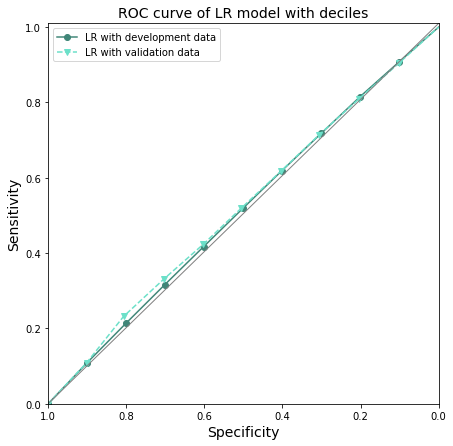

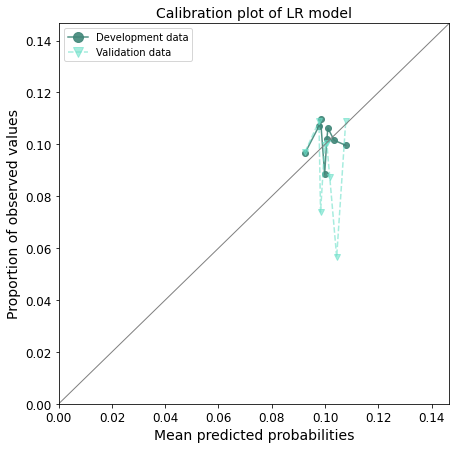

In [92]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_ot_externa_no_abs_incdt_during_pandemic, prob_pred_ot_externa_no_abs_incdt_during_pandemic_bin = cox_build('ot_externa', 'incdt_during_pandemic', data_ot_externa_incdt_during_pandemic, data_ot_externa_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('ot_externa', 'incdt_during_pandemic_deciles', prob_pred_ot_externa_no_abs_incdt_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('ot_externa', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)#, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 47715 total observations, 47396 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 47715
number of events observed = 319
   partial log-likelihood = -3423.65
         time fit was run = 2023-08-08 08:58:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.16            -0.34             0.30                 0.71                 1.35
CCI_cat[T.medium]               -0.02       0.98       0.18            -0.37             0.34                 0.69                 1.40
CCI_cat[T.high]                 -0.28       0.76       0.23            -0.74             0.18                 0.48                 1.20
CCI_cat[T.very_high]            -0.08       0.92       0.19            -0.46             0.30                 0.63                 1.35
age_cat[T.25_34]                 0.41       1.50       0.22            -0.02             0.83                 0.98                 2.29
age_cat[T.35_44]                 0.13       1.14       0.23            -0.31             0.58                 0.73                 1.78
age_cat[T.45_54]                 0.26       1.30       0.22            -0.17             0.69                 0.84                 2.00
age_cat[T.55_64]                 0.18       1.19       0.22            -0.26             0.62                 0.77                 1.86
age_cat[T.65_74]                 0.14       1.15       0.23            -0.30             0.59                 0.74                 1.80
age_cat[T.75_more]               0.39       1.48       0.22            -0.03             0.81                 0.97                 2.26
antibacterial_brit               0.06       1.06       0.04            -0.02             0.13                 0.98                 1.14
bmi_cat[T.obese]                 0.00       1.00       0.21            -0.40             0.41                 0.67                 1.50
bmi_cat[T.overweight]           -0.08       0.92       0.26            -0.58             0.42                 0.56                 1.52
bmi_cat[T.underweight]          -0.15       0.86       0.39            -0.90             0.61                 0.40                 1.83
bmi_cat[T.unknown]              -0.09       0.92       0.22            -0.53             0.35                 0.59                 1.42
ethnicity[T.other]               0.13       1.14       0.30            -0.46             0.71                 0.63                 2.04
ethnicity[T.unknown]             0.00       1.00       0.25            -0.48             0.49                 0.62                 1.63
ethnicity[T.white]               0.18       1.19       0.23            -0.27             0.63                 0.76                 1.87
flu_vaccine[T.yes]               0.12       1.13       0.18            -0.22             0.47                 0.80                 1.60
imd[T.medium]                   -0.16       0.85       0.18            -0.52             0.19                 0.60                 1.21
imd[T.unaffluent]               -0.15       0.86       0.18            -0.51             0.20                 0.60                 1.23
imd[T.unknown]                  -0.16       0.85       0.29            -0.72             0.40                 0.49                 1.50
imd[T.very_affluent]             0.03       1.03       0.17            -0.31             0.37                 0.73                 1.44
imd[T.very_unaffluent]          -0.14       0.87       0.18            -0.49             0.22                 0.61                 1.24
region[T.east_midlands]          0.37       1.45       0

13040


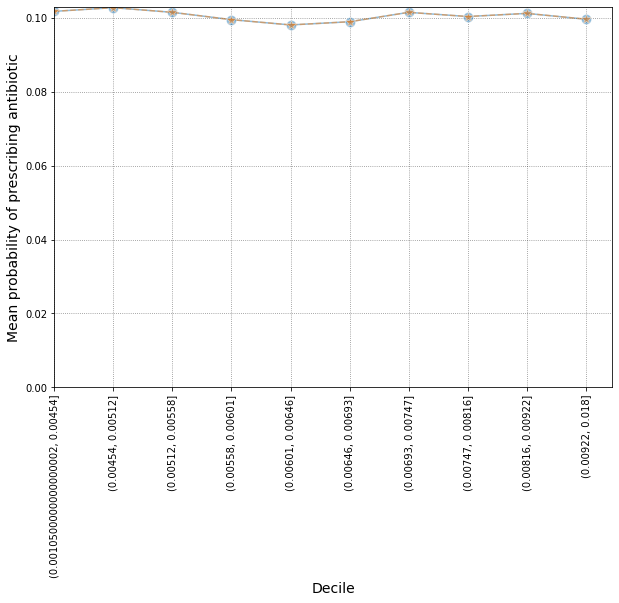


AUROC of LR for deciles with development and validation data: 0.50856 and 0.48259
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00454, 0.00512] -0.025831       -0.148574        0.096913   
1  bins_(0.00512, 0.00558] -0.050536       -0.181011        0.079940   
2  bins_(0.00558, 0.00601] -0.009792       -0.141801        0.122218   
3  bins_(0.00601, 0.00646] -0.042061       -0.177708        0.093586   
4  bins_(0.00646, 0.00693] -0.044611       -0.184557        0.095334   
5  bins_(0.00693, 0.00747] -0.001411       -0.126526        0.123705   
6  bins_(0.00747, 0.00816] -0.014910       -0.134858        0.105039   
7  bins_(0.00816, 0.00922]  0.045242       -0.083025        0.173510   
8    bins_(0.00922, 0.018] -0.044344       -0.183429        0.094741   

         or  or_lower_95%  or_upper_95%  
0  0.974500      0.861936      1.101765  
1  0.950720      0.834426      1.083222  
2  0.990256      0.867794      1.130001  
3  0.958811    

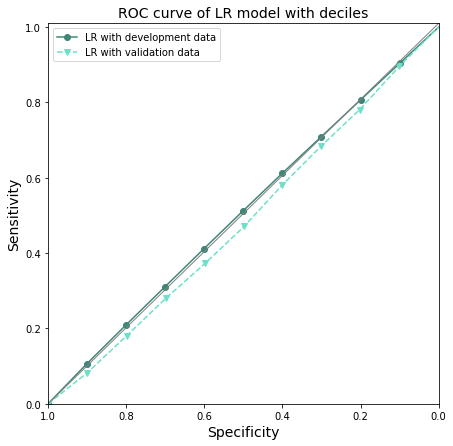

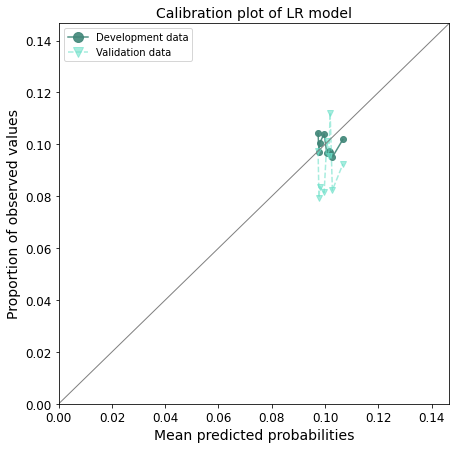

In [93]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_ot_externa_no_abs_incdt_post_2nd_lockdown, prob_pred_ot_externa_no_abs_incdt_post_2nd_lockdown_bin = cox_build('ot_externa', 'incdt_post_2nd_lockdown', data_ot_externa_incdt_post_2nd_lockdown, data_ot_externa_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('ot_externa', 'incdt_post_2nd_lockdown_deciles', prob_pred_ot_externa_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('ot_externa', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)#, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3099 total observations, 3085 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 3099
number of events observed = 14
   partial log-likelihood = -92.81
         time fit was run = 2023-08-08 08:59:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.72            -1.66             1.14                 0.19                 3.13
CCI_cat[T.medium]               -1.49       0.23       1.17            -3.78             0.80                 0.02                 2.22
CCI_cat[T.high]                 -1.03       0.36       1.18            -3.34             1.28                 0.04                 3.58
CCI_cat[T.very_high]            -0.71       0.49       0.94            -2.55             1.13                 0.08                 3.11
age_cat[T.25_34]                 0.73       2.07       1.24            -1.70             3.16                 0.18                23.52
age_cat[T.35_44]                 0.01       1.01       1.42            -2.78             2.81                 0.06                16.56
age_cat[T.45_54]                 0.84       2.31       1.17            -1.44             3.12                 0.24                22.72
age_cat[T.55_64]                -0.16       0.85       1.44            -2.98             2.66                 0.05                14.24
age_cat[T.65_74]                 1.53       4.60       1.11            -0.65             3.70                 0.52                40.40
age_cat[T.75_more]              -0.02       0.98       1.42            -2.81             2.78                 0.06                16.04
antibacterial_brit               0.18       1.19       0.19            -0.19             0.54                 0.83                 1.72
bmi_cat[T.obese]                -0.07       0.93       1.11            -2.25             2.10                 0.11                 8.20
bmi_cat[T.overweight]            0.91       2.48       1.19            -1.42             3.23                 0.24                25.34
bmi_cat[T.underweight]         -17.75       0.00   12332.30        -24188.61         24153.11                 0.00                  inf
bmi_cat[T.unknown]               0.66       1.94       1.12            -1.54             2.86                 0.22                17.49
ethnicity[T.other]               0.33       1.39   10117.46        -19829.53         19830.19                 0.00                  inf
ethnicity[T.unknown]            18.15   7.60e+07    7379.46        -14445.34         14481.63                 0.00                  inf
ethnicity[T.white]              18.22   8.15e+07    7379.46        -14445.27         14481.70                 0.00                  inf
flu_vaccine[T.yes]               0.65       1.92       0.68            -0.67             1.98                 0.51                 7.22
imd[T.medium]                   -1.40       0.25       1.14            -3.63             0.83                 0.03                 2.29
imd[T.unaffluent]               -0.80       0.45       0.89            -2.54             0.94                 0.08                 2.57
imd[T.unknown]                 -18.31       0.00    8455.36        -16590.51         16553.89                 0.00                  inf
imd[T.very_affluent]            -0.27       0.76       0.78            -1.81             1.26                 0.16                 3.54
imd[T.very_unaffluent]          -0.01       0.99       0.73            -1.43             1.42                 0.24                 4.13
region[T.east_midlands]        -19.42       0.00    8269.09   

13173


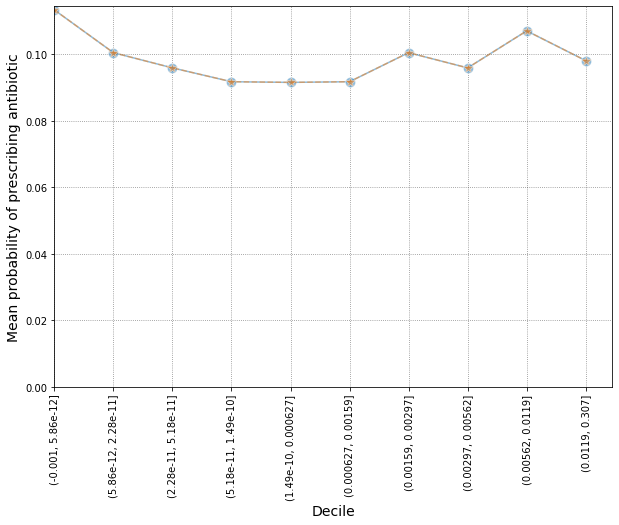


AUROC of LR for deciles with development and validation data: 0.52649 and 0.46933
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.000627, 0.00159] -0.163734       -0.576139        0.248670   
1    bins_(0.00159, 0.00297] -0.290397       -0.686617        0.105823   
2    bins_(0.00297, 0.00562] -0.258220       -0.699119        0.182679   
3     bins_(0.00562, 0.0119] -0.161716       -0.616973        0.293541   
4       bins_(0.0119, 0.307] -0.208873       -0.640718        0.222972   
5  bins_(1.49e-10, 0.000627] -0.325651       -0.742295        0.090992   
6  bins_(2.28e-11, 5.18e-11] -0.289750       -0.698269        0.118768   
7  bins_(5.18e-11, 1.49e-10] -0.167271       -0.541709        0.207168   
8  bins_(5.86e-12, 2.28e-11] -0.222660       -0.629179        0.183859   

         or  or_lower_95%  or_upper_95%  
0  0.848968      0.562064      1.282319  
1  0.747966      0.503276      1.111625  
2  0.772425      0.497023      1.2004

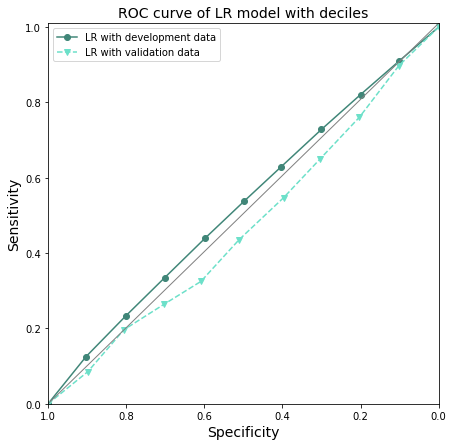

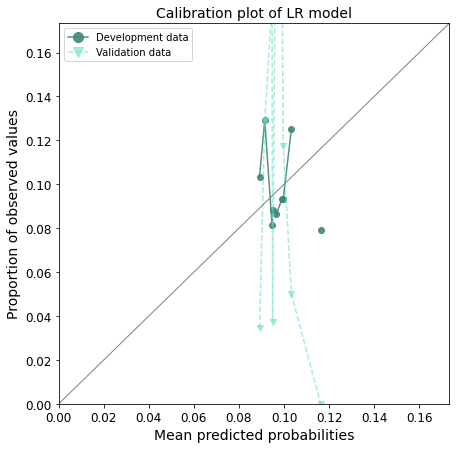

In [94]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_ot_externa_no_abs_prevl_prepandemic, prob_pred_ot_externa_no_abs_prevl_prepandemic_bin = cox_build('ot_externa', 'prevl_prepandemic', data_ot_externa_prevl_prepandemic, data_ot_externa_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('ot_externa', 'prevl_prepandemic_deciles', prob_pred_ot_externa_no_abs_prevl_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('ot_externa', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)#, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2900 total observations, 2881 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 2900
number of events observed = 19
   partial log-likelihood = -126.62
         time fit was run = 2023-08-08 08:59:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.54       0.58       0.67            -1.86             0.77                 0.16                 2.17
CCI_cat[T.medium]               -0.33       0.72       0.73            -1.77             1.10                 0.17                 3.02
CCI_cat[T.high]                 -1.23       0.29       1.14            -3.46             1.01                 0.03                 2.74
CCI_cat[T.very_high]            -0.13       0.88       0.73            -1.56             1.31                 0.21                 3.70
age_cat[T.25_34]                18.32   9.04e+07    5114.62        -10006.16         10042.80                 0.00                  inf
age_cat[T.35_44]                16.74   1.87e+07    5114.62        -10007.73         10041.22                 0.00                  inf
age_cat[T.45_54]                18.67   1.28e+08    5114.62        -10005.81         10043.14                 0.00                  inf
age_cat[T.55_64]                18.01   6.65e+07    5114.62        -10006.46         10042.49                 0.00                  inf
age_cat[T.65_74]                17.55   4.17e+07    5114.62        -10006.93         10042.02                 0.00                  inf
age_cat[T.75_more]              17.98   6.41e+07    5114.62        -10006.50         10042.45                 0.00                  inf
antibacterial_brit               0.13       1.14       0.16            -0.18             0.44                 0.84                 1.56
bmi_cat[T.obese]                -1.50       0.22       0.74            -2.95            -0.06                 0.05                 0.95
bmi_cat[T.overweight]           -0.32       0.72       0.80            -1.89             1.24                 0.15                 3.46
bmi_cat[T.underweight]         -18.69       0.00   10249.99        -20108.29         20070.92                 0.00                  inf
bmi_cat[T.unknown]              -0.64       0.53       0.74            -2.09             0.80                 0.12                 2.23
ethnicity[T.other]              -1.63       0.20       1.18            -3.95             0.68                 0.02                 1.98
ethnicity[T.unknown]            -0.59       0.55       0.73            -2.03             0.85                 0.13                 2.33
ethnicity[T.white]              -1.27       0.28       0.69            -2.62             0.08                 0.07                 1.09
flu_vaccine[T.yes]               0.97       2.64       0.59            -0.19             2.13                 0.83                 8.37
imd[T.medium]                   -0.93       0.39       1.17            -3.22             1.36                 0.04                 3.89
imd[T.unaffluent]                0.95       2.59       0.72            -0.46             2.37                 0.63                10.66
imd[T.unknown]                   0.36       1.44       1.18            -1.94             2.67                 0.14                14.45
imd[T.very_affluent]             0.62       1.86       0.75            -0.84             2.09                 0.43                 8.07
imd[T.very_unaffluent]           0.37       1.45       0.83            -1.26             2.01                 0.28                 7.44
region[T.east_midlands]         -1.41       0.25       1.14  

13228


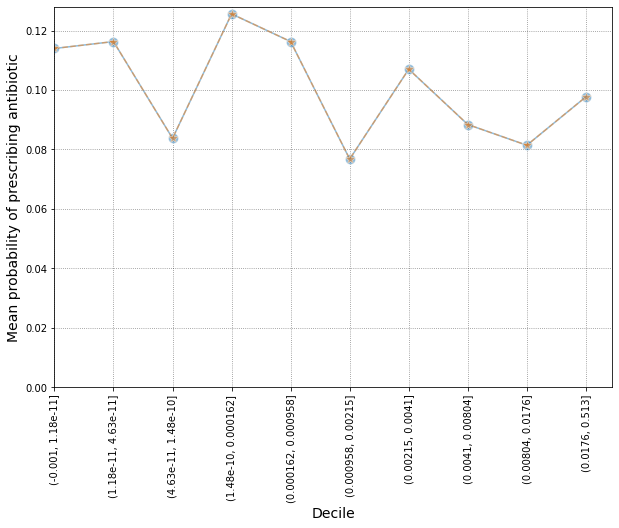


AUROC of LR for deciles with development and validation data: 0.56037 and 0.51757
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.000162, 0.000958]  0.128785       -0.343253        0.600823   
1   bins_(0.000958, 0.00215] -0.276389       -0.723763        0.170985   
2     bins_(0.00215, 0.0041] -0.111691       -0.536165        0.312783   
3     bins_(0.0041, 0.00804] -0.121656       -0.587184        0.343872   
4     bins_(0.00804, 0.0176] -0.438949       -0.863421       -0.014477   
5       bins_(0.0176, 0.513] -0.244159       -0.662079        0.173761   
6  bins_(1.18e-11, 4.63e-11] -0.030006       -0.442439        0.382426   
7  bins_(1.48e-10, 0.000162]  0.187610       -0.298225        0.673446   
8  bins_(4.63e-11, 1.48e-10] -0.398089       -0.817198        0.021020   

         or  or_lower_95%  or_upper_95%  
0  1.137445      0.709458      1.823619  
1  0.758518      0.484924      1.186473  
2  0.894320      0.584987      1.3672

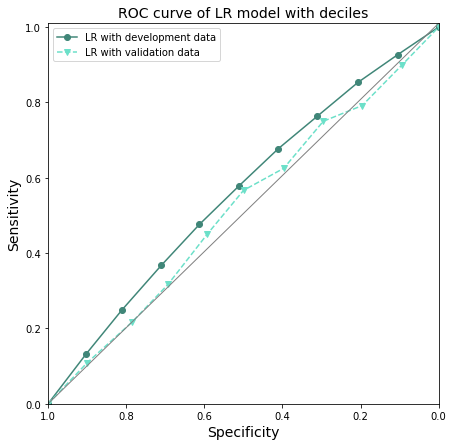

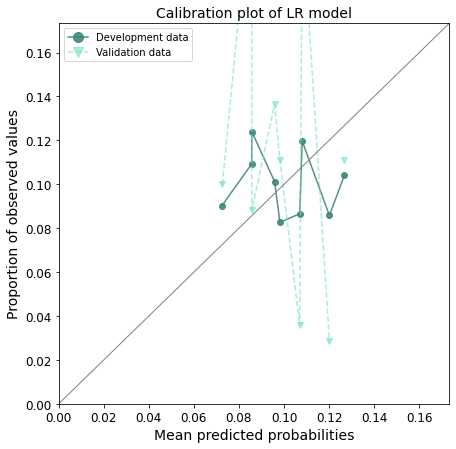

In [95]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_ot_externa_no_abs_prevl_during_pandemic, prob_pred_ot_externa_no_abs_prevl_during_pandemic_bin = cox_build('ot_externa', 'prevl_during_pandemic', data_ot_externa_prevl_during_pandemic, data_ot_externa_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('ot_externa', 'prevl_during_pandemic_deciles', prob_pred_ot_externa_no_abs_prevl_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('ot_externa', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)#, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5257 total observations, 5212 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 5257
number of events observed = 45
   partial log-likelihood = -352.11
         time fit was run = 2023-08-08 08:59:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.81       0.44       0.42            -1.64             0.01                 0.19                 1.01
CCI_cat[T.medium]               -0.48       0.62       0.45            -1.36             0.39                 0.26                 1.48
CCI_cat[T.high]                 -0.28       0.75       0.54            -1.34             0.77                 0.26                 2.16
CCI_cat[T.very_high]            -0.35       0.70       0.46            -1.26             0.55                 0.28                 1.74
age_cat[T.25_34]                -0.30       0.74       0.61            -1.50             0.90                 0.22                 2.45
age_cat[T.35_44]                -0.26       0.77       0.61            -1.45             0.94                 0.23                 2.55
age_cat[T.45_54]                 0.22       1.25       0.54            -0.84             1.29                 0.43                 3.64
age_cat[T.55_64]                 0.16       1.18       0.54            -0.90             1.23                 0.41                 3.42
age_cat[T.65_74]                 0.58       1.79       0.51            -0.42             1.58                 0.66                 4.86
age_cat[T.75_more]              -1.32       0.27       0.82            -2.92             0.29                 0.05                 1.34
antibacterial_brit              -0.03       0.97       0.11            -0.24             0.18                 0.79                 1.19
bmi_cat[T.obese]                -0.14       0.87       0.46            -1.03             0.75                 0.36                 2.12
bmi_cat[T.overweight]           -2.07       0.13       1.09            -4.19             0.06                 0.02                 1.06
bmi_cat[T.underweight]           0.35       1.42       0.72            -1.06             1.76                 0.35                 5.83
bmi_cat[T.unknown]              -1.12       0.33       0.58            -2.26             0.02                 0.10                 1.02
ethnicity[T.other]               1.40       4.04       1.12            -0.81             3.60                 0.45                36.61
ethnicity[T.unknown]             1.67       5.32       1.03            -0.35             3.69                 0.70                40.22
ethnicity[T.white]               1.14       3.11       1.02            -0.87             3.14                 0.42                23.20
flu_vaccine[T.yes]               0.19       1.21       0.48            -0.75             1.13                 0.47                 3.09
imd[T.medium]                   -0.32       0.73       0.50            -1.30             0.66                 0.27                 1.93
imd[T.unaffluent]                0.19       1.21       0.43            -0.66             1.04                 0.52                 2.84
imd[T.unknown]                   0.37       1.44       0.60            -0.81             1.55                 0.44                 4.69
imd[T.very_affluent]            -0.86       0.42       0.60            -2.03             0.30                 0.13                 1.36
imd[T.very_unaffluent]          -0.26       0.77       0.48            -1.20             0.67                 0.30                 1.96
region[T.east_midlands]          1.64       5.14       0.78  

13089


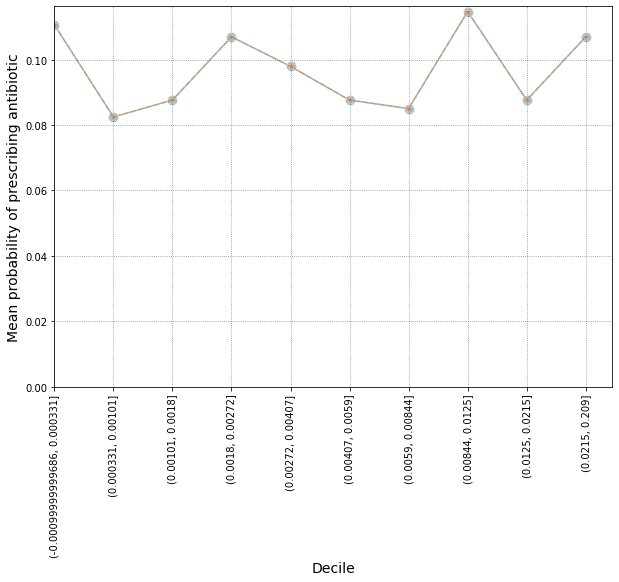


AUROC of LR for deciles with development and validation data: 0.54576 and 0.49560
LR summary:
                   covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.000331, 0.00101] -0.420987       -0.802761       -0.039213   
1    bins_(0.00101, 0.0018] -0.229320       -0.583737        0.125098   
2    bins_(0.0018, 0.00272] -0.031003       -0.346183        0.284177   
3   bins_(0.00272, 0.00407] -0.006521       -0.316854        0.303812   
4    bins_(0.00407, 0.0059] -0.141444       -0.494000        0.211113   
5    bins_(0.0059, 0.00844] -0.394598       -0.761927       -0.027269   
6    bins_(0.00844, 0.0125]  0.095745       -0.252244        0.443734   
7     bins_(0.0125, 0.0215] -0.071589       -0.383959        0.240780   
8      bins_(0.0215, 0.209] -0.020621       -0.355449        0.314207   

         or  or_lower_95%  or_upper_95%  
0  0.656399      0.448090      0.961546  
1  0.795074      0.557810      1.133259  
2  0.969473      0.707383      1.328668  
3  0.

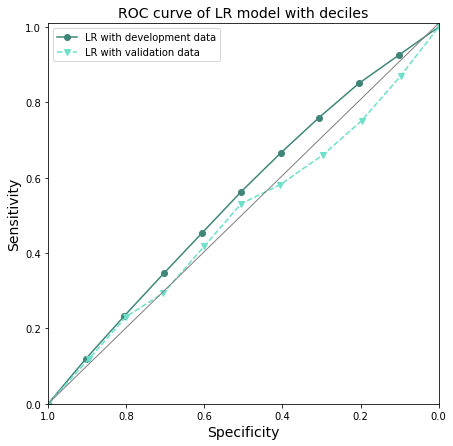

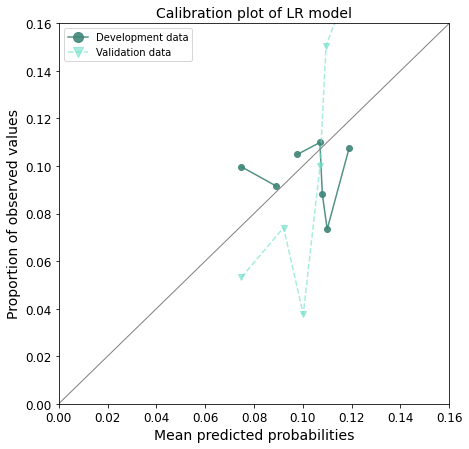

: 

In [96]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_ot_externa_no_abs_prevl_post_2nd_lockdown, prob_pred_ot_externa_no_abs_prevl_post_2nd_lockdown_bin = cox_build('ot_externa', 'prevl_post_2nd_lockdown', data_ot_externa_prevl_post_2nd_lockdown, data_ot_externa_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('ot_externa', 'prevl_post_2nd_lockdown_deciles', prob_pred_ot_externa_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('ot_externa', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)#, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")